## MNIST CNN

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from keras.metrics import categorical_accuracy
from keras.models import Sequential
from keras.layers import  Conv2D, Dense, Dropout, Flatten, Lambda, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

%matplotlib inline

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


## Preprocessing

In [2]:
train = pd.read_csv('./data/mnist/train.csv')

In [3]:
X_train = train.drop('label', axis=1)
y_train = train.label

In [4]:
X_test = pd.read_csv('./data/mnist/test.csv')

In [5]:
X_train = X_train.values.reshape(-1, 1, 28, 28)
X_train.shape

(42000, 1, 28, 28)

In [6]:
X_test = X_test.values.reshape(-1, 1, 28, 28)

In [7]:
del train

In [8]:
def onehot(y, num_classes=None):
    """Converts a class vector (integers) to binary class matrix.
    E.g. for use with categorical_crossentropy.
    # Arguments
        y: class vector to be converted into a matrix
            (integers from 0 to num_classes).
        num_classes: total number of classes.
    # Returns
        A binary matrix representation of the input.
    """
    y = np.array(y, dtype='int').ravel()
    if not num_classes:
        num_classes = np.max(y) + 1
    n = y.shape[0]
    categorical = np.zeros((n, num_classes))
    categorical[np.arange(n), y] = 1

    return categorical

In [9]:
Y_train = onehot(y_train, num_classes=10)

In [10]:
#Y_val = onehot(y_val, num_classes=10)

In [11]:
# Split into training and validation sets
#X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2)

## Visualization

In [12]:
def plot(X, titles=None, rows=1, figsize=(12,6), cmap='gray'):
    f = plt.figure(figsize=figsize)
    l = min(len(X), 100) # protect the kernel
    cols = l // rows if l % 2 == 0 else l // rows + 1
    for i in range(l):
        sp = f.add_subplot(rows, cols, i + 1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        im = X[i].reshape(28, 28).astype(np.uint8)
        plt.imshow(im, cmap=cmap)

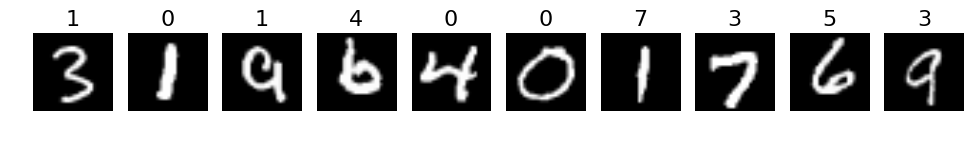

In [13]:
plot(X_train[-10:], titles=y_train, rows=1)

## CNN Model

In [14]:
def get_model():
    model = Sequential([
        BatchNormalization(axis=1, input_shape=(1,28,28)),
        Conv2D(32,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(32,3,3, activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Conv2D(64,3,3, activation='relu'),
        BatchNormalization(axis=1),
        Conv2D(64,3,3, activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [15]:
# Ensemble
models = [get_model() for i in range(6)]

In [75]:
for i, m in enumerate(models):
    m.load_weights('data/mnist/cnn-mnist-noval2-' + str(i) + '.pkl')

## Training

In [52]:
gen = ImageDataGenerator(
    rotation_range=12, 
    width_shift_range=0.1, 
    shear_range=0.3,
    height_shift_range=0.1, 
    zoom_range=0.1)

In [19]:
batches = gen.flow(X_train, Y_train, batch_size=64)

In [ ]:
#val_batches = gen.flow(X_val, Y_val, batch_size=64)

In [ ]:
# Fit
for i, m in enumerate(models):
    print 'Model %d/%d' % (i + 1, len(models))
    m.fit_generator(batches, batches.N, nb_epoch=1)#, validation_data=val_batches, nb_val_samples=val_batches.N)
    m.optimizer.lr = 0.1
    m.fit_generator(batches, batches.N, nb_epoch=4)#, validation_data=val_batches, nb_val_samples=val_batches.N)
    m.optimizer.lr = 0.01
    m.fit_generator(batches, batches.N, nb_epoch=8)#, validation_data=val_batches, nb_val_samples=val_batches.N)
    m.optimizer.lr = 0.001
    m.fit_generator(batches, batches.N, nb_epoch=8)#, validation_data=val_batches, nb_val_samples=val_batches.N)

In [86]:
for i, m in enumerate(models):
    m.save_weights('data/mnist/cnn-mnist-noval2-' + str(i) + '.pkl')

## Predictions

In [87]:
predictions = np.array([m.predict(X_test, batch_size=256) for m in models])

In [88]:
labels = np.max(predictions, axis=0)
labels.shape

(28000, 10)

In [89]:
labels = np.argmax(labels, axis=1)
labels.shape

(28000,)

In [90]:
imageIds = np.arange(1, len(labels) + 1)
imageIds.shape

(28000,)

In [91]:
subm = np.stack([imageIds, labels], axis=1)
subm[:5]

array([[1, 2],
       [2, 0],
       [3, 9],
       [4, 0],
       [5, 3]])

## Submission

In [92]:
subm_filename = 'subm.csv'

In [93]:
np.savetxt(subm_filename, subm, fmt='%d,%d', header='ImageId,Label', comments='')

In [94]:
from IPython.display import FileLink
FileLink(subm_filename)

/home/ubuntu/nbs/deep-learning/subm.csv